In [15]:
import os
from mtools.plot_preamble import *
from mtools import check_dir, load_json, list_set
import mtools.monkey as mk

'''
    根据 displacement_list 重建轨迹
    Input:
        displacement_list: np.array(N, 2 or 3) N个连续时间的相对位移
    Output:
        traj: np.array(N, 2 or 3): 重建的轨迹
'''
def recon_traj_with_preds(displacement_list):
    if displacement_list.shape[1] == 3:
        pos_now = np.array([0,0,0], dtype="float64")
    elif displacement_list.shape[1] == 2:
        pos_now = np.array([0,0], dtype="float64")

    traj = [pos_now.copy()]
    for dis in displacement_list:
        pos_now += dis
        traj.append(pos_now.copy())
    
    return np.array(traj)

def compute_absolute_trajectory_error(est, gt):
    """
    Args:
        est: estimated trajectory
        gt: ground truth trajectory. It must have the same shape as est.
    Return:
        Absolution trajectory error, which is the Root Mean Squared Error betweentwo trajectories.
    """
    return np.sqrt(np.mean((est - gt) ** 2)), np.std(np.sqrt((est - gt) ** 2))

In [17]:
poses = ['pocket', 'handbag', 'trolley']
names = poses
out_dir = '/mnt/lun2/home/wjk/workspace/DeepTrack/output/pdr'
for pose in poses:
    data_path = osp.join(out_dir, f'pred_all_{pose}.npy')
    print(data_path)
    with open(data_path, 'rb') as f:
        pdr_pos_pred = np.load(f,allow_pickle=True)
        pdr_trip_id_all = np.load(f,allow_pickle=True)[:, 0]
        pdr_ts_pred_all = np.load(f,allow_pickle=True)
        gt_pos_all = np.load(f,allow_pickle=True)
        pdr_trip_list = np.load(f,allow_pickle=True)
        print(pdr_pos_pred.shape, pdr_trip_id_all.shape, pdr_ts_pred_all.shape, gt_pos_all.shape)
        f.close()
        mk.magic_append([pdr_pos_pred, pdr_trip_id_all, pdr_ts_pred_all, gt_pos_all, pdr_trip_list])
[pdr_pos_pred_list, pdr_trip_id_all_list, pdr_ts_pred_all_list, gt_pos_all_list, pdr_trip_list] = mk.magic_get()

/mnt/lun2/home/wjk/workspace/DeepTrack/output/pdr/pred_all_pocket.npy
(61885, 2) (61885,) (61885,) (61885, 2)
/mnt/lun2/home/wjk/workspace/DeepTrack/output/pdr/pred_all_handbag.npy
(44485, 2) (44485,) (44485,) (44485, 2)
/mnt/lun2/home/wjk/workspace/DeepTrack/output/pdr/pred_all_trolley.npy
(20829, 2) (20829,) (20829,) (20829, 2)


In [24]:
def eval_tracking_domain(pdr_pos_pred, gt_pos_all, start_ind=0, step_size=100, length=2000):
    ate_list = []
    n = pdr_pos_pred.shape[0]
    for j in range((n-start_ind-length)//step_size):
        _start_ind=start_ind+j*step_size
        est = pdr_pos_pred[_start_ind:_start_ind+length] - pdr_pos_pred[_start_ind]
        gt = gt_pos_all[_start_ind:_start_ind+length] - gt_pos_all[_start_ind]
        ate, ate_std = compute_absolute_trajectory_error(est, gt)
        ate_list.append([start_ind, ate, ate_std])
    return np.array(ate_list)



df_list = []
for pdr_pos_pred, gt_pos_all, pose in zip(pdr_pos_pred_list, gt_pos_all_list, poses):
    data = eval_tracking_domain(pdr_pos_pred, gt_pos_all)
    df = pd.DataFrame(data, columns=['start_ind', 'ate', 'ate_std'])
    df['domain'] = pose
    df_list.append(df)
df = pd.concat(df_list)
df.drop('start_ind', axis=1, inplace=True)
df = df.groupby('domain').mean().reset_index()
df['method'] = 'PDR'
display(df)


,domain,ate,ate_std,method
0,handbag,1.9076,1.1338,PDR
1,pocket,2.1309,1.2533,PDR
2,trolley,4.0786,2.3643,PDR


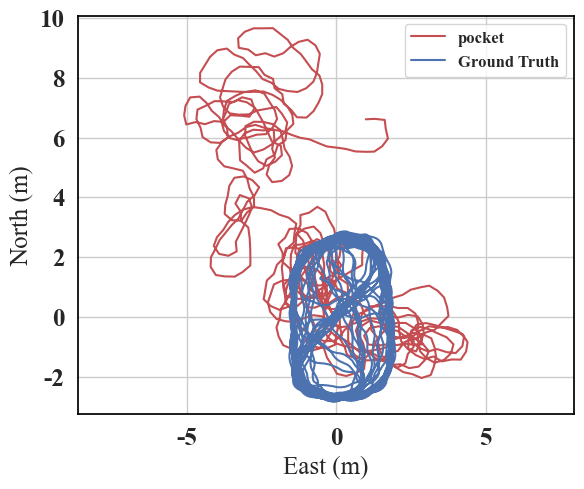

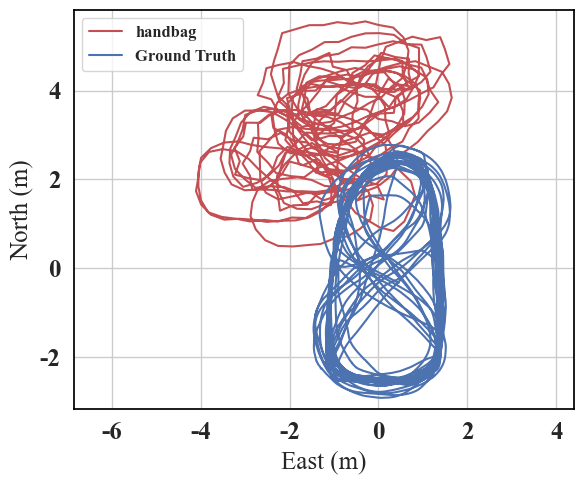

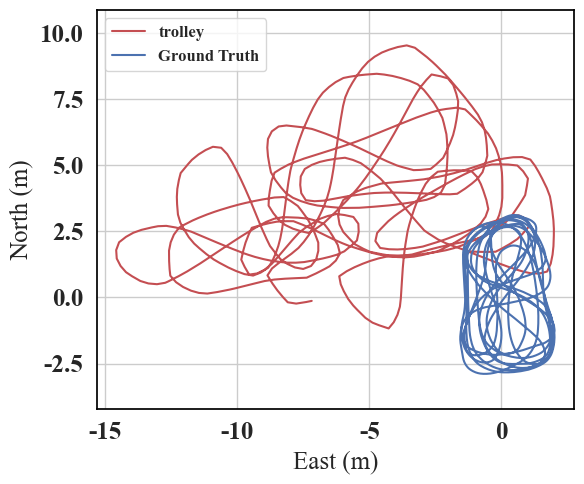

In [19]:
def plot_traj(traj_pred_list, gt_pos_all_list, title=None):
    for j in range(len(traj_pred_list)):
        fig, ax = plt.subplots(figsize=(6, 5))
        ax.plot(traj_pred_list[j][:, 0], traj_pred_list[j][:, 1], 'r', label=names[j])
        ax.plot(gt_pos_all_list[j][:, 0], gt_pos_all_list[j][:, 1], 'b', label="Ground Truth")
        # ax.plot(marks_gt[:, 0], marks_gt[:, 1], f'{cs[j+1]}o')
        ax.set_xlabel("East (m)", fontsize=18, fontstyle='normal')
        ax.set_ylabel("North (m)", fontsize=18, fontstyle='normal')
        ax.axis('equal')
        ax.legend(fontsize=12)
        if title is not None:
            ax.set_title(title, fontsize=18, fontstyle='normal')
        fig.tight_layout()
        # if fig_name is not None:
        #     check_dir(osp.join(out_dir, osp.dirname(fig_name)), is_print=False)
        #     fig.savefig(osp.join(out_dir, fig_name), dpi=300)
        #     print(f'save png to {osp.join(out_dir, fig_name)}')
        #     plt.close(fig)

plot_traj(pdr_pos_pred_list, gt_pos_all_list)